# Integration of stiff ODEs

#### Benjamin Vogel 

In [42]:
import numpy as np
import scipy as scp
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# 2.  Brusselator

## TASK 1,2,3: Definition of Integration Methods

In [43]:
#
# previously defined methods
#

def forward_euler(f,y,h,t):
    '''
    f   : ODE function f(t,y(t))
    y   : current evaluation
    h   : time step size
    t   : current time
    
    uses left euler method to approximate integral 
    '''
    return y + h * f(t,y), t+h , h


def backward_euler(f,y,h,t):
    def implicit_eq(y_next):
        return y_next - y - h * f(t + h, y_next)
    y_next = fsolve(implicit_eq, y)
    return y_next, t+h , h


def explicit_RK_2(f,y,h,t):
    '''
    f   : ODE function f(t,y(t))
    y   : current evaluation
    h   : time step size
    t   : current time
    
    uses second order Runge-Kutta method to approximate integral 
    '''
    k1 = f(t,y)
    k2 = f(t+h/2, y + (h/2)*k1)
    return y + h*k2, t+h , h

In [44]:
#
# RK-4 Implementation
#

def explicit_RK_4(f,y,h,t):
    '''
    f   : ODE function f(t,y(t))
    y   : current evaluation
    h   : time step size
    t   : current time
    
    uses fourth order Runge-Kutta method to approximate integral 
    '''
    k1 = f(t,y)
    k2 = f(t+h/2, y+(h/2)*k1)
    k3 = f(t+h/2, y+(h/2)*k2)
    k4 = f(t+h, y + h*k3)
    return y + (h/6)*(k1+2*k2+2*k3+k4), t+h , h

In [51]:
#
# Embedded RK-3
#
def embedd_RK_3(f,y,h,t,tol=1e-9, debug=False):
    '''
    f   : ODE function f(t,y(t))
    y   : current evaluation
    h   : time step size
    t   : current time
    tol : tolerance used to compute opt h
    '''
    c1 = 0
    c2 = 1/3
    c3 = 2/3
    c4 = 1
    
    b1 = 1/8
    b2 = 3/8
    b3 = 3/8
    b4 = 1/8
    
    k1 = f(t,y)
    k2 = f(t + c2*h , y + (h/3)*k1)
    k3 = f(t + c3*h , y - (h/3)*k1 + h*k2)
    k4 = f(t + c4*h , y + h* (k1 - k2 + k3))
    
    y1 = y + h*(b1*k1 + b2*k2 + b3*k3 + b4*k4)
    
    b1_hat = 2*b1 - 1/6
    b2_hat = 2*(1-c2)*b2
    b3_hat = 2*(1-c3)*b3
    b4_hat = 0
    b5_hat = 1/6

    k5 = f(t+ h, y1)
    
    y1_hat = y + h*(b1_hat*k1 + b2_hat*k2 + b3_hat*k3 + b4_hat*k4 + b5_hat*k5)
    
    err = np.sqrt(np.mean(np.power((y1-y1_hat)/(1+np.maximum(np.abs(y1),np.abs(y1_hat))),2)))
    
    opt_step1 = 0.9 * (tol/err)**(1/(3+1))
    opt_h = h*np.minimum(5, np.maximum(0.2, opt_step1))
    
    if debug:
        print("Tol:", err*(opt_step1/(0.9*h))**(3+1))
    if err <= tol:
        return y1 , t + h, opt_h
    else:
        return y1 , t, opt_h

In [46]:
#
# defining the IVP solver
#

def IVP(f,y_init,h,time,method=forward_euler):
    # storage for evaluations at every iteration
    steps = [y_init]
    t_values = [0]
    current_time = 0
    y_current = y_init
    h_step = h
    
    while current_time < time:
        y_next, t_next, h_next = method(f, y_current, h_step, current_time)
        if np.isclose(t_next,current_time):
            h_step = h_next
        else:
            steps.append(y_next)
            current_time += h_step
            t_values.append(current_time)
            
            h_step = np.minimum(h_next, time-h_step)
            y_current = y_next
    
    return np.array(t_values), np.array(steps)

In [47]:
def visualize_IVP(ts, ys, descirption="Diagramm"):
    plt.plot(ts,ys,label=descirption)

### What is Radau5 and how does it work?
Radau5 is a fully implicit 5th order runge-kutta method and is part of the Radau IIA methods. The method also uses a 3rd order embeded method to approximate errors and adapt the step size.

Regarding the radau methods butcher table, one node is fixed. 
For the Radau5 method, the fixed node is the right endpoint (at x=1). For an s=3 stage method, like Radau5, the nodes $c_i$ are the roots of the equation: $$\frac{d^{s-1}}{dx^{s-1}}(x^{s-1}(x-1)^s)$$
The weights $b_i$ for the Radau methods are chosen using the quadrature conditions:
$$\sum_{i=1}^s b_i c_i^{q-1} = \frac{1}{q} \quad \forall \text{q=1,...,s}$$ 

Because Radau5 is a implicit method, a nonlinear equation(s) has to be iteratively solved. Newtons method is used to solve these nonlinear equations, having to solve a linear system of equations every step. The system is going to be the size of "number of stages $s$ times number of differential equations $n$". Because this is increadibly expensive to solve, the $n$ times $s$ dimensional system gets decomposed into s n-dimensional systems.

Radau methods are A-stable methods, meaning that the stability domain covers $\mathbb{C}^-$

Sources:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.Radau.html#r04c194a64501-1
https://www.sciencedirect.com/science/article/pii/S037704279900134X

## The Model

In [19]:
#
# defining the model and exact solution
#

def model(t,y,alpha=1,beta=3):
    '''
    t : current time t
    y : evaluation of y at time t
    l : lambda parameter > 1
    '''
    
    dy = np.zeros(2)
    dy[0] += 1 + alpha*(y[0]**2)*y[1] - (1+beta)*y[0]
    dy[1] += -alpha*(y[0]**2)*y[1] + beta*y[0]
    return dy

## TASK 1: Stiffness of the system

## **Analysis of System Stability**
---

### **Jacobian Matrix**

The Jacobian matrix $ J(y) $ is given by:

$$
\begin{equation}
J(y) =
\begin{bmatrix}
\frac{\partial f_1}{\partial y_1} & \frac{\partial f_1}{\partial y_2} \\
\frac{\partial f_2}{\partial y_1} & \frac{\partial f_2}{\partial y_2} 
\end{bmatrix}
\end{equation}
$$
---

#### **Where** :

$$ \
f_1 = 1 + ay_1^2(t)y_2(t) - (1+b) y_1(t),
\
\
f_2 = -ay_1^2(t)y_2(t) + by_1(t).
\
\ $$

---


---

### **Partial Derivatives**

#### From $ f_1 = 1 + ay_1^2(t)y_2(t) - (b+1) y_1(t) $:

$$
\frac{\partial f_1}{\partial y_1} = 2ay_1(t)y_2(t)-(1+b),
$$

$$
\frac{\partial f_1}{\partial y_2} = ay_1^2(t).
$$

#### From $ f_2 = -ay_1^2(t)y_2(t) + by_1(t) $:

$$
\frac{\partial f_2}{\partial y_1} = -2ay_1(t)y_2(t)+b,
$$

$$
\frac{\partial f_2}{\partial y_2} = -ay_1^2(t).
$$

---
### **Find the equilibrium of the system**

Find $y_1$ and $y_2$ such that
$$
\begin{cases}
f1 = 1 + ay_1^2(t)y_2(t) - (1+b) y_1(t) = 0\\
f2 = -ay_1^2(t)y_2(t) + by_1(t) = 0
\end{cases}
$$

#### From $f_2 = -ay_1^2(t)y_2(t) + by_1(t) = 0$:
$$
y_2 = \frac{b}{ay_1}
$$

#### Into $f_1 = 1 + ay_1^2(t)y_2(t) - (1+b) y_1(t) = 0$:
$$
y_1 = 1
$$

Thus, the equilibrium point is as $(1,\frac{b}{a})$

---

### **Constructing the Jacobian**

With $a=1$ and $b=3$\
Substituting the partial derivatives, the Jacobian matrix becomes:

$$
J(y) =
\begin{bmatrix}
2y_1(t)y_2(t)-4 & y_1^2(t)\\
-2y_1(t)y_2(t)+3 & y_1^2(t)
\end{bmatrix}.
$$

---



In [20]:
# Initialization
a = 1
b = 3
y1, y2 = 1, a/b # equilibrium 

# Jacobian matrix

J = np.array([
    [2*a*y1*y2-(b+1), a*y1**2],
    [-2*a*y1*y2+b, -a*y1**2]
])

# Eigenvalues  & time step h
eigenvalues, _ = np.linalg.eig(J)
lambda_max = np.max(np.abs(eigenvalues))
min_step = 2/ np.abs(lambda_max)

print(f"Jacobian Matrix at y = [1,{b/a}]:\n", J)
print("\n Eigenvalues of the Jacobian ( λ ):", eigenvalues)

Jacobian Matrix at y = [1,3.0]:
 [[-3.33333333  1.        ]
 [ 2.33333333 -1.        ]]

 Eigenvalues of the Jacobian ( λ ): [-4.08876043 -0.2445729 ]


## TASK 2: Plot IVP (Experimentation)

In [21]:
#
# the following function plots IVP with different time steps and plots
#
def plot_IVP(f,y_init,time,six_time_steps=[0.01,0.1,0.2,0.3,0.4,0.5],method=forward_euler):
    '''
    plots y_n+1 / y_n along side the acctual outputs
    '''
    fig, axs = plt.subplots(3, 2, figsize=(15, 10)) 
    axs = axs.flatten()
    steps = six_time_steps
    k = 0
    for h in steps:
        ts,vs = IVP(f,y_init,h,time,method)
        amp = []
        for idx in range(len(vs)-1):
            r = (vs[idx+1]/vs[idx])
            amp.append(r)
        #axs[k].plot(ts[1:],amp, label=f"amplification")
        axs[k].plot(ts,vs, label=f"IVP")
        axs[k].set_title(f"h = {h}")
        axs[k].set_xlabel(f"t")
        axs[k].set_ylim(-5,5)
        axs[k].legend()
        axs[k].grid()
        k += 1
    fig.tight_layout()
    

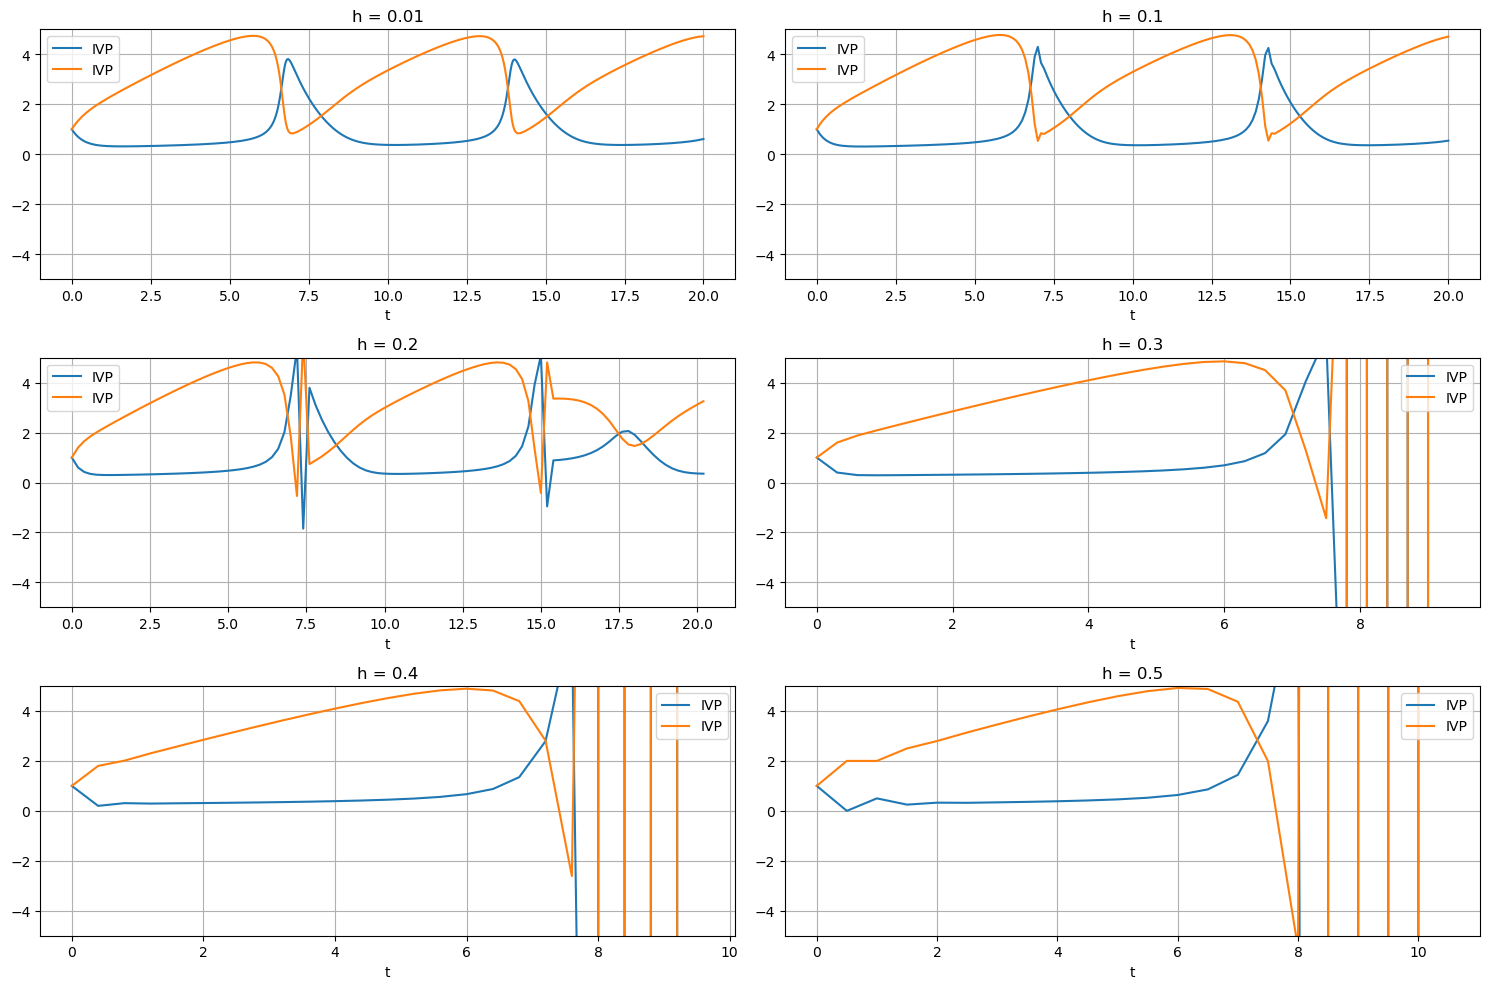

In [22]:
#
# forward euler
#
m = lambda t,y : model(t,y)
plot_IVP(m,np.array([1,1]),20)

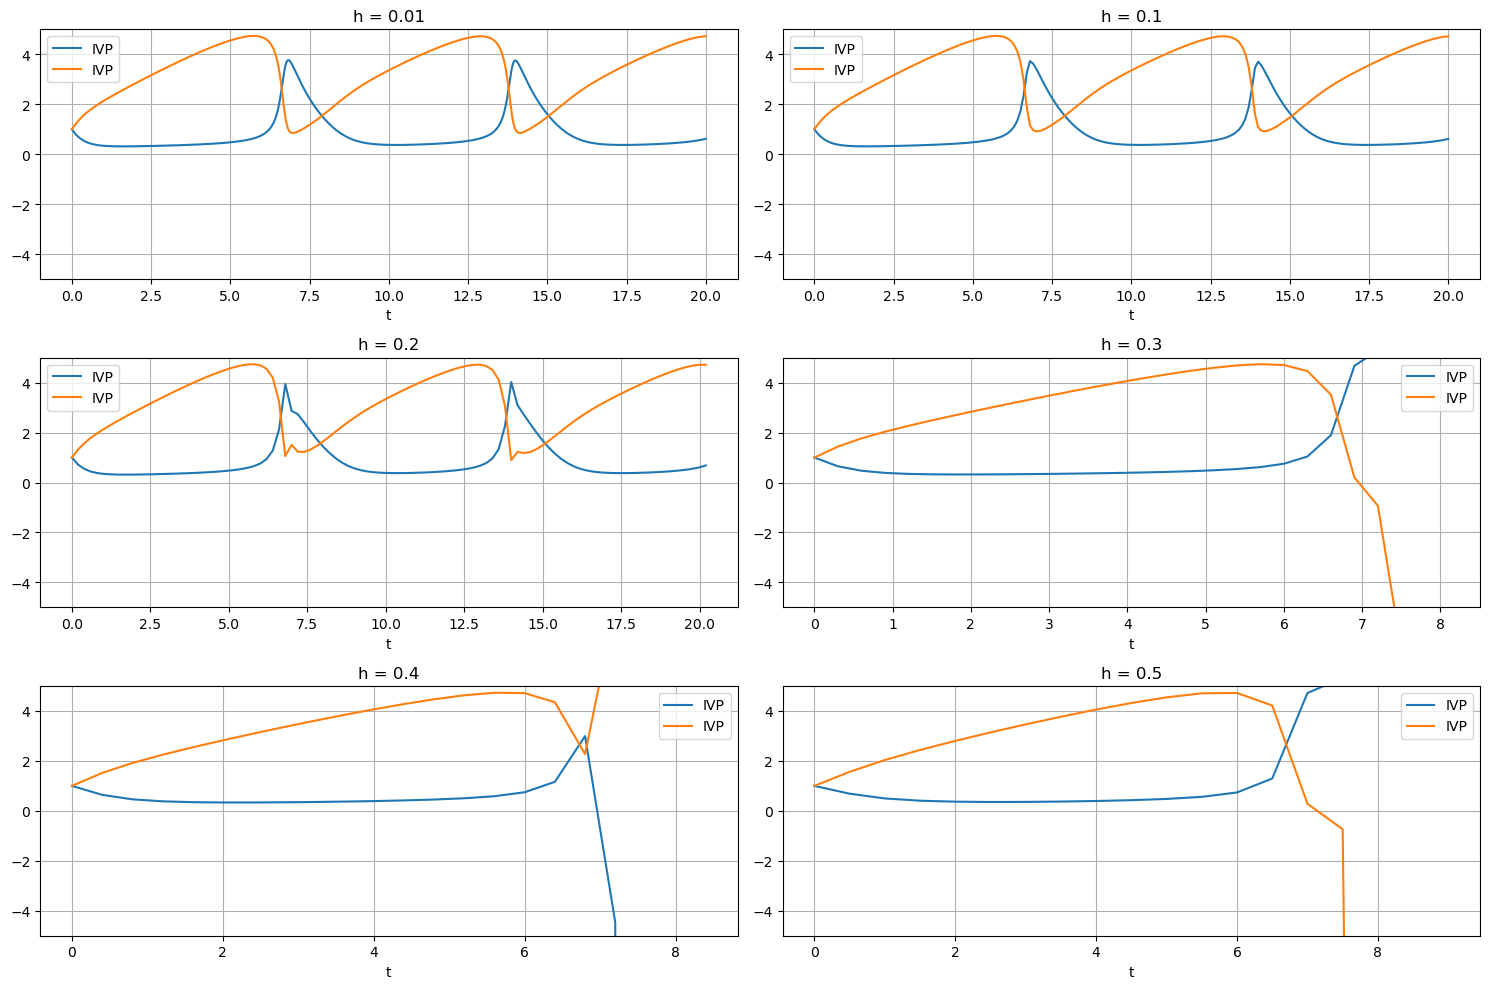

In [23]:
#
# 2-RK
#
m = lambda t,y : model(t,y)
plot_IVP(m,np.array([1,1]),20,method=explicit_RK_2)

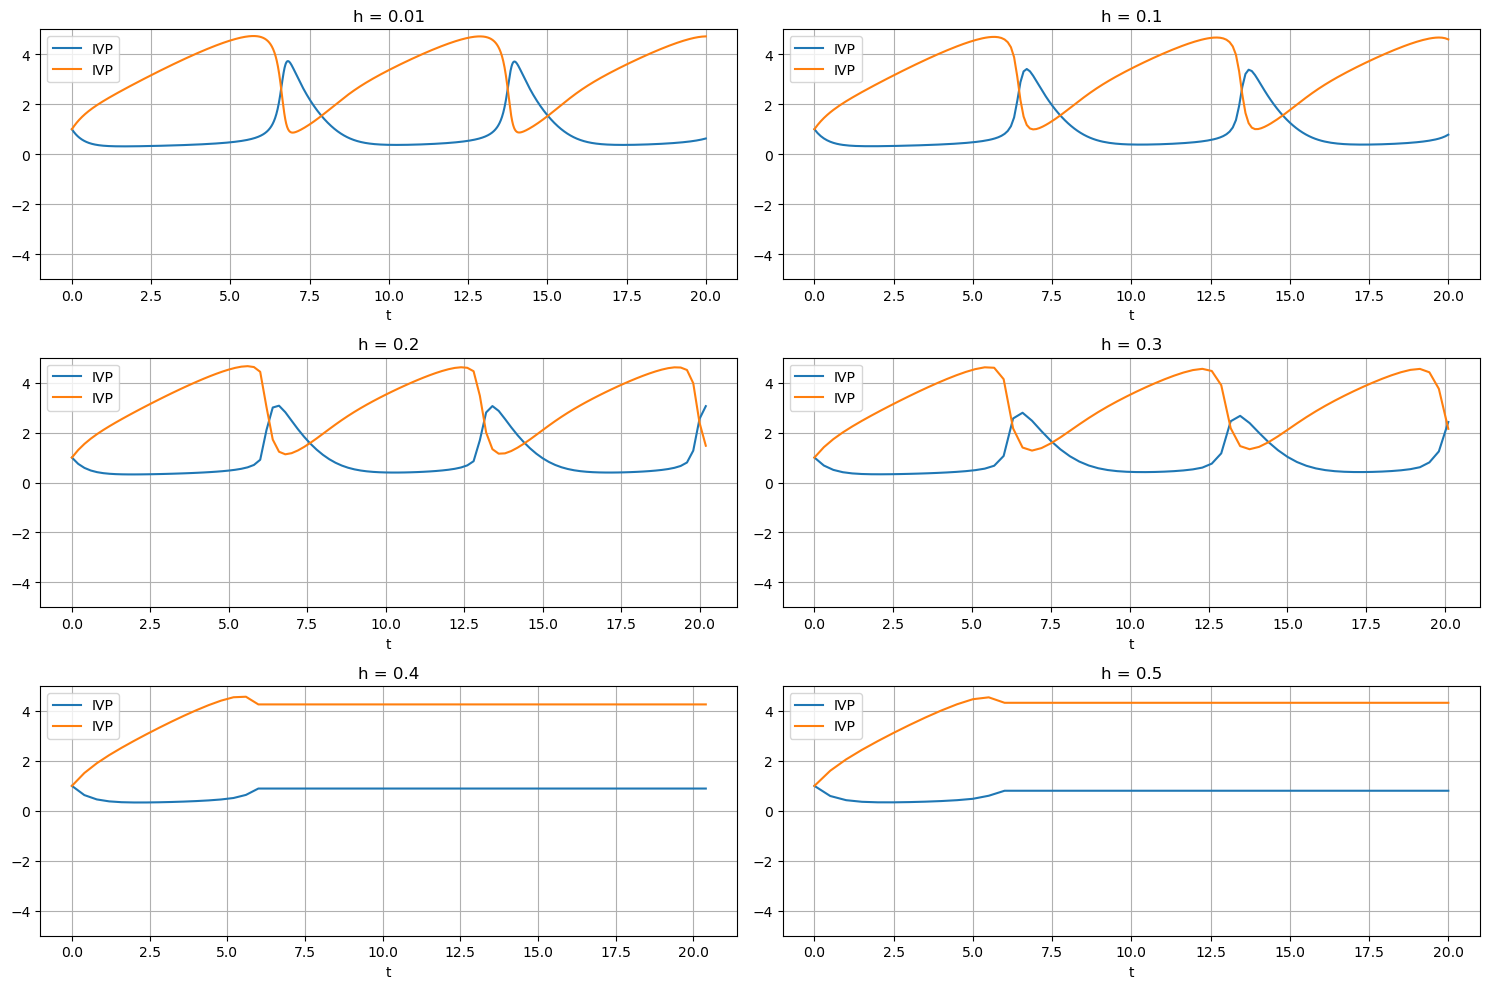

In [24]:
m = lambda t,y : model(t,y)
plot_IVP(m,np.array([1,1]),20,method=backward_euler)

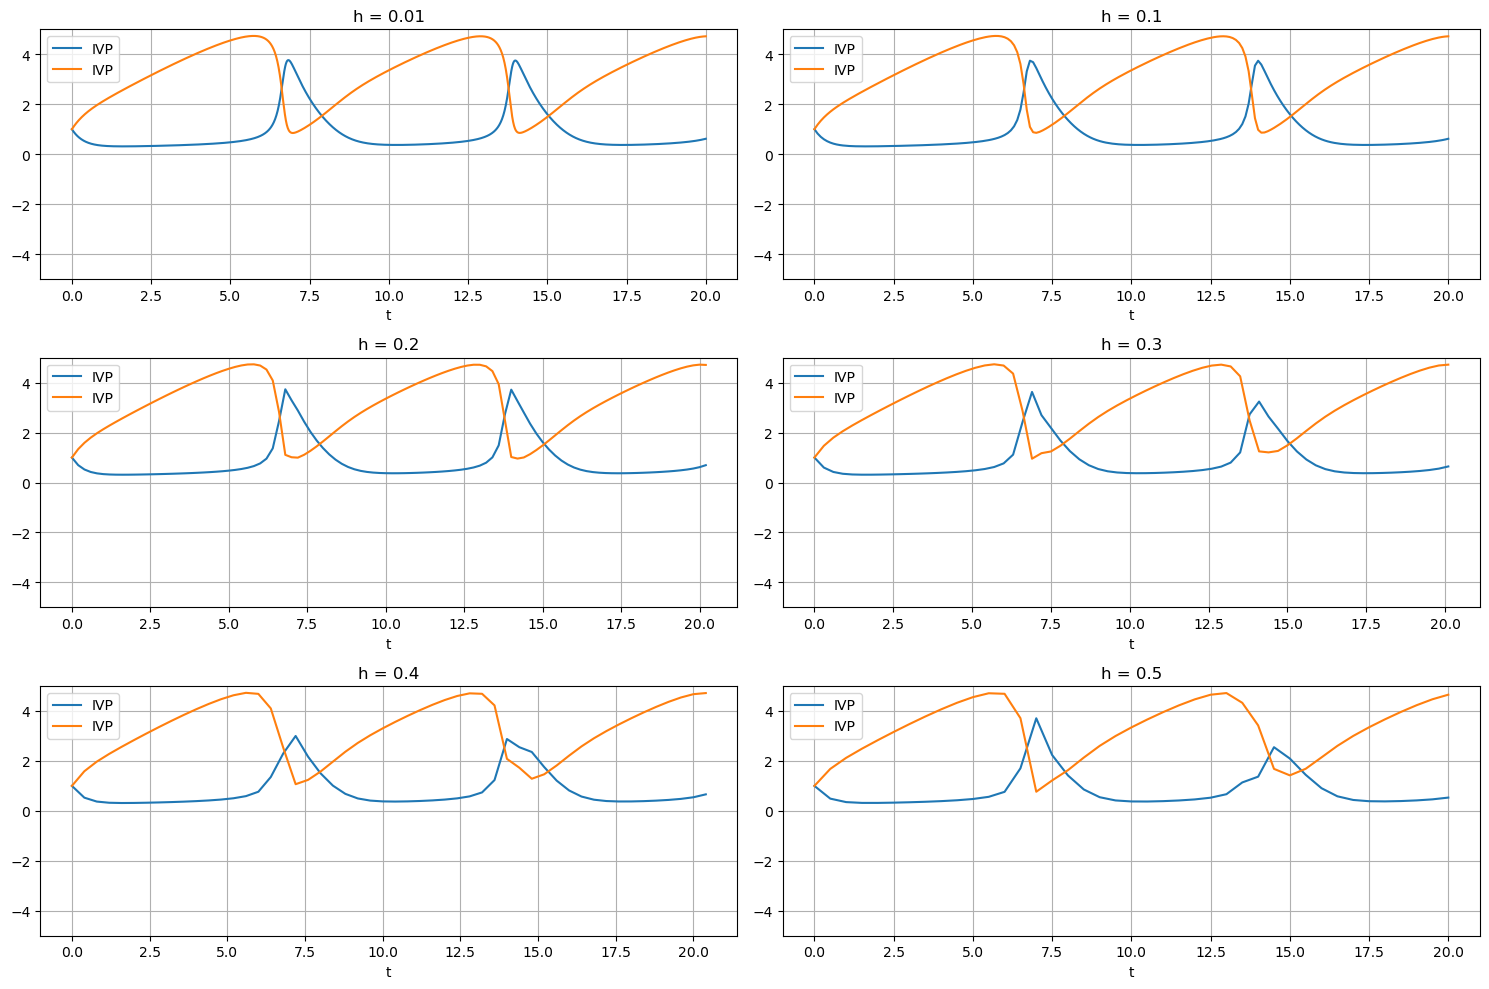

In [25]:
m = lambda t,y : model(t,y)
plot_IVP(m,np.array([1,1]),20,method=explicit_RK_4)

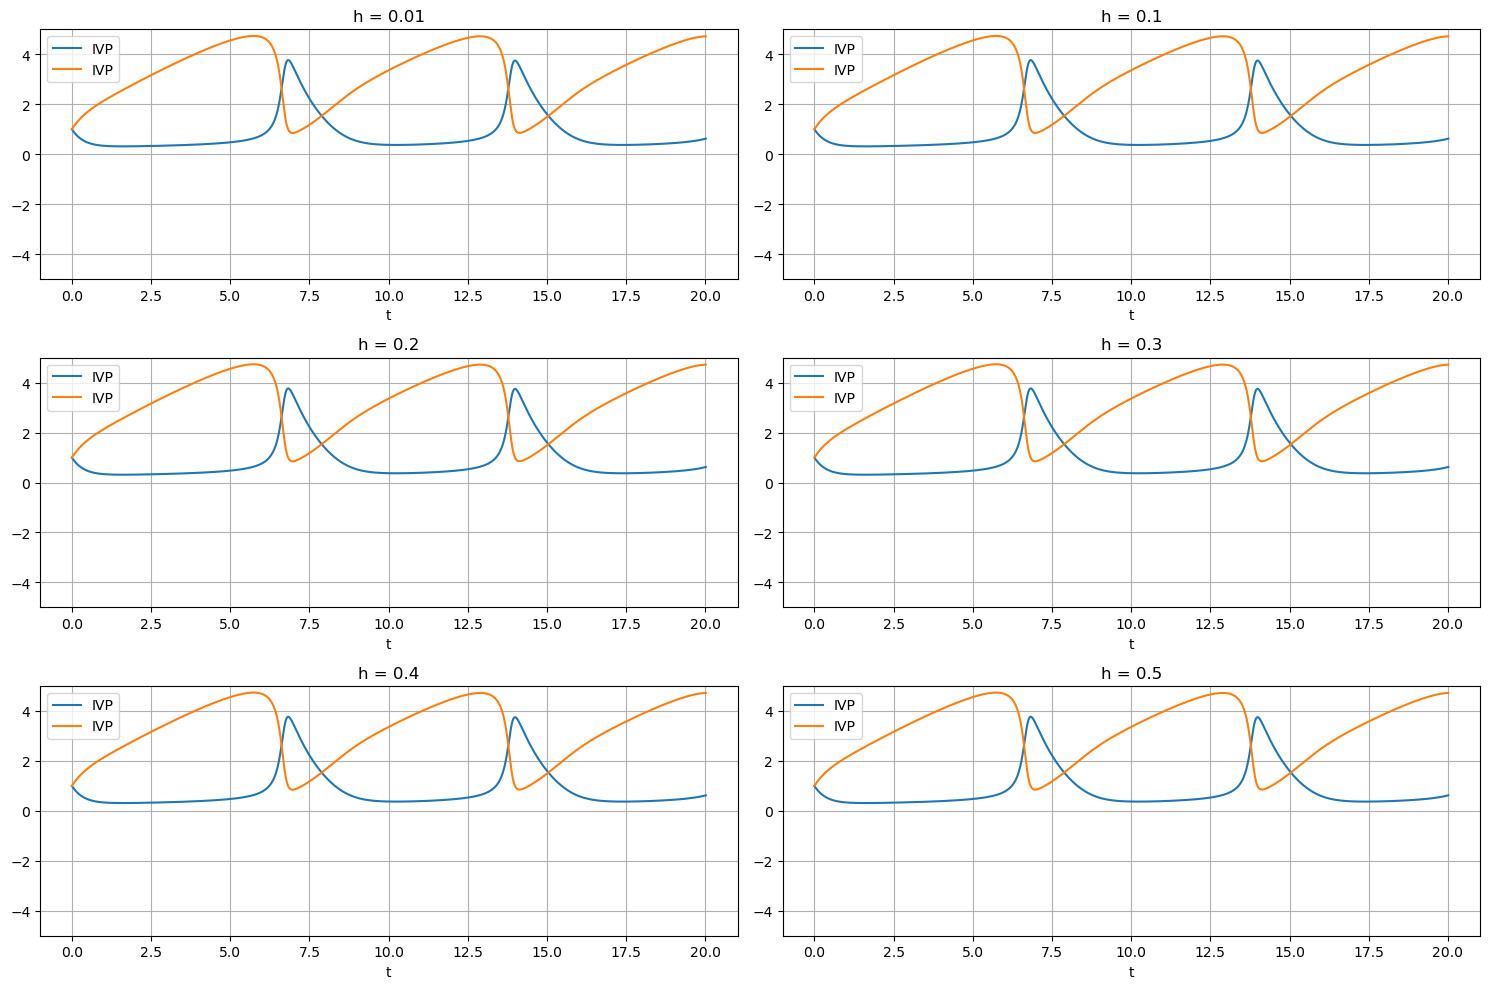

In [26]:
m = lambda t,y : model(t,y)
plot_IVP(m,np.array([1,1]),20,method=embedd_RK_3)

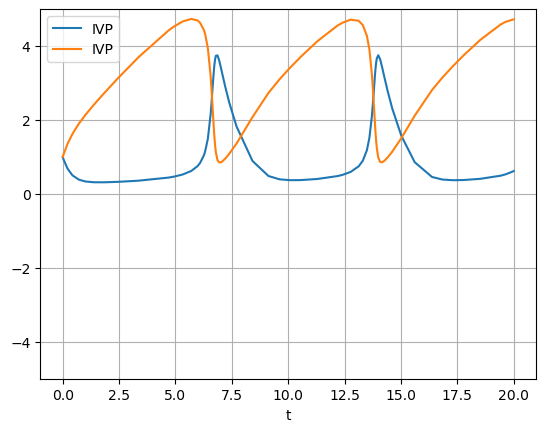

In [27]:
m = lambda t,y : model(t,y)

def radau_gen(f,y,t):
    rad_obj = scp.integrate.Radau(f,0,y,t)
    while True:
        rad_obj.step()
        yield rad_obj.y, rad_obj.t, rad_obj.step_size
        if rad_obj.t == t:
            break
ts = [0]
ys = [[1,1]]
for y,t,h in radau_gen(m,np.array([1,1]),20):
    ts.append(t)
    ys.append(y)
    
plt.plot(ts,ys, label=f"IVP")
plt.xlabel(f"t")
plt.ylim(-5,5)
plt.legend()
plt.grid()

## TASK 3: Stability limits of the explicit methods

In [28]:
# Explicit Eular Stability region.  
def forward_stability():
    x_space = np.linspace(-3, 3, 500)
    y_space = np.linspace(-3, 3, 500)
    X, Y = np.meshgrid(x_space, y_space)
    
    # Stability condition: Circle centered at (-1, 0) with radius 1
    condition = (1+X)**2 + Y**2
    
    plt.contourf(X, Y, condition, levels=[0, 1], colors=['lightgreen'], alpha=0.5)  
    plt.contourf(X, Y, condition, levels=[1, 100], colors=['red'], alpha=0.5)       
    plt.contour(X, Y, condition, levels=[1], colors='blue', linewidths=1.5)         
    
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.title('Stability Region for Forward Euler Method', fontsize=12)
    plt.xlabel('Re(hλ)', fontsize=10)
    plt.ylabel('Im(hλ)', fontsize=10)
    plt.grid(alpha=0.3)


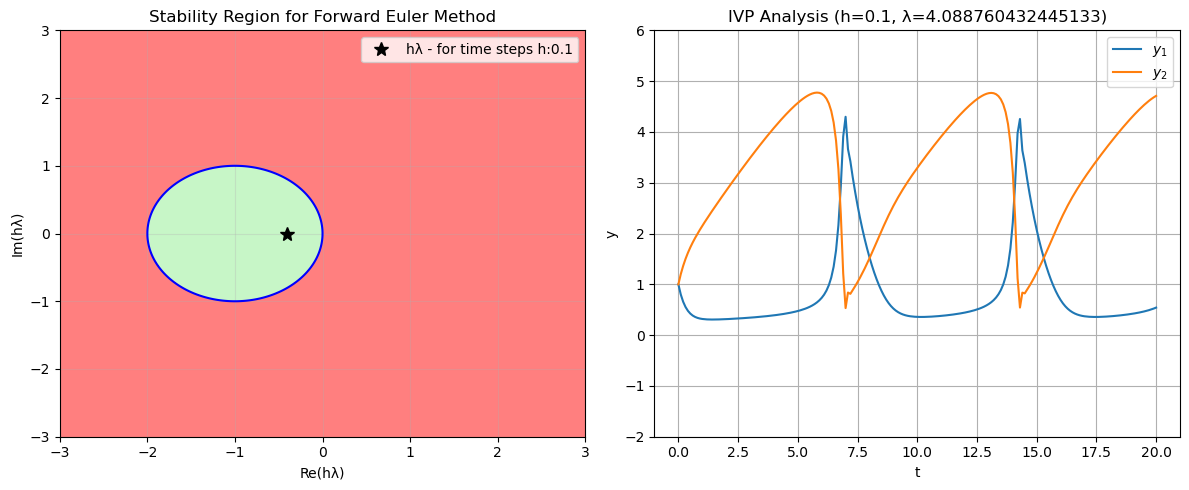

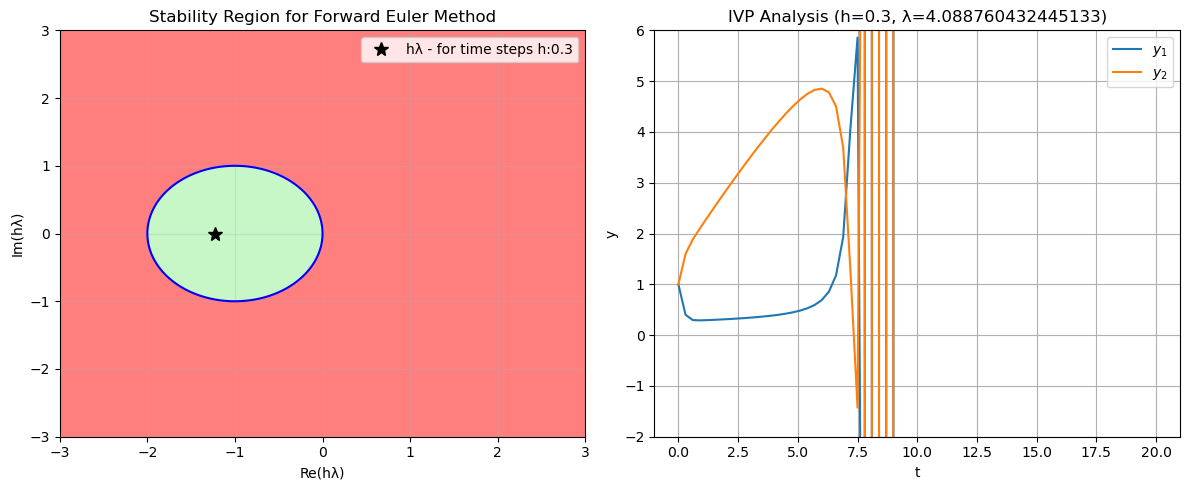

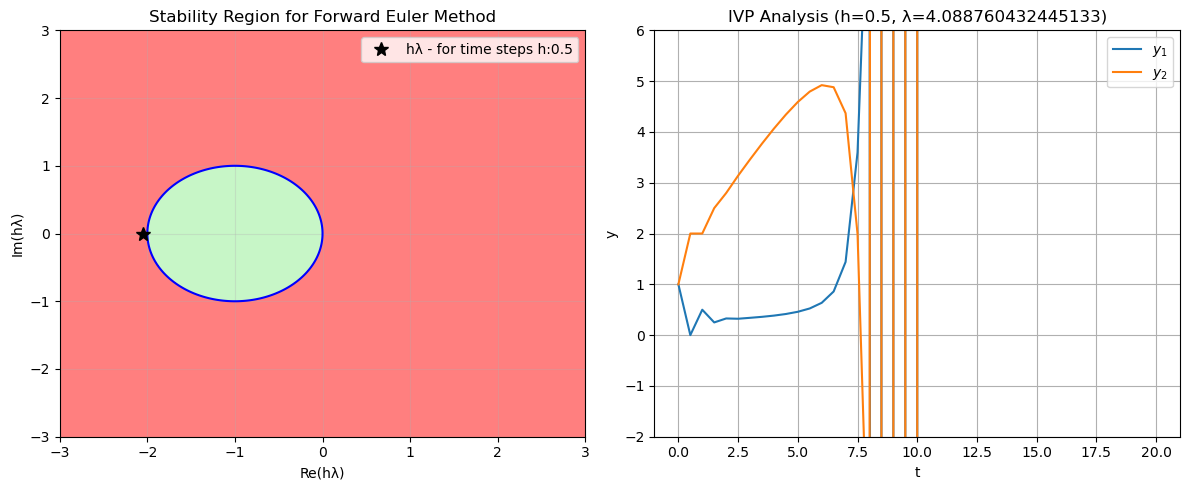

In [29]:
def plot_point(h, l):
    x = h * -l
    plt.plot(x.real, x.imag, '*', color='black', markersize=10, label=f'hλ - for time steps h:{h}')
    plt.legend()

h_values = [0.1, 0.3, 0.5]  
l = lambda_max
a = 1
b = 3


for h in h_values:
    plt.figure(figsize=(12, 5))
    
    # Left plot: Stability region 
    plt.subplot(1, 2, 1)
    forward_stability()        
    plot_point(h, l)          
    
    # Right plot: Exact and discretized solutions 
    plt.subplot(1, 2, 2)
    visualize_IVP(*IVP(lambda t,y : model(t,y,alpha=a,beta=b),np.array([1,1]),h,20,method=forward_euler), ["$y_1$","$y_2$"])
    plt.xlabel("t")
    plt.ylabel("y")
    plt.title(f"IVP Analysis (h={h}, λ={l})")
    plt.xlim([-1, 21])
    plt.ylim([-2, 6])
    plt.legend()
    plt.grid()
    
    plt.tight_layout()
    plt.show()


In [30]:
# Runge-Kutta 2nd Order Stability region 

def explicit_RK_2_stability():
    x_space = np.linspace(-3, 3, 500)
    y_space = np.linspace(-3, 3, 500)
    X, Y = np.meshgrid(x_space, y_space)
    
    Re_G = 1 + X + (X**2)/2 - (Y**2)/2  
    Im_G = Y +  X * Y       
    G_magnitude = np.sqrt(Re_G**2 + Im_G**2)  #
    
    plt.contourf(X, Y, G_magnitude, levels=[0, 1], colors=['lightgreen'], alpha=0.5)  
    plt.contourf(X, Y, G_magnitude, levels=[1, 100], colors=['red'], alpha=0.5)       
    plt.contour(X, Y, G_magnitude, levels=[1], colors='blue', linewidths=1.5)         
    
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.title('Stability Region for 2nd Order Runge-Kutta Method', fontsize=12)
    plt.xlabel('Re(hλ)', fontsize=10)
    plt.ylabel('Im(hλ)', fontsize=10)
    plt.grid(alpha=0.3)


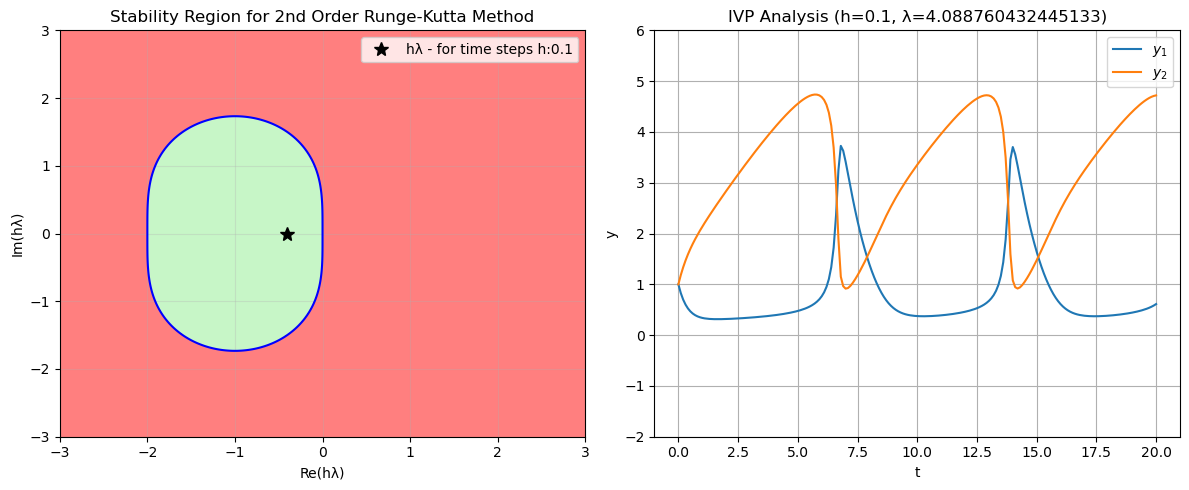

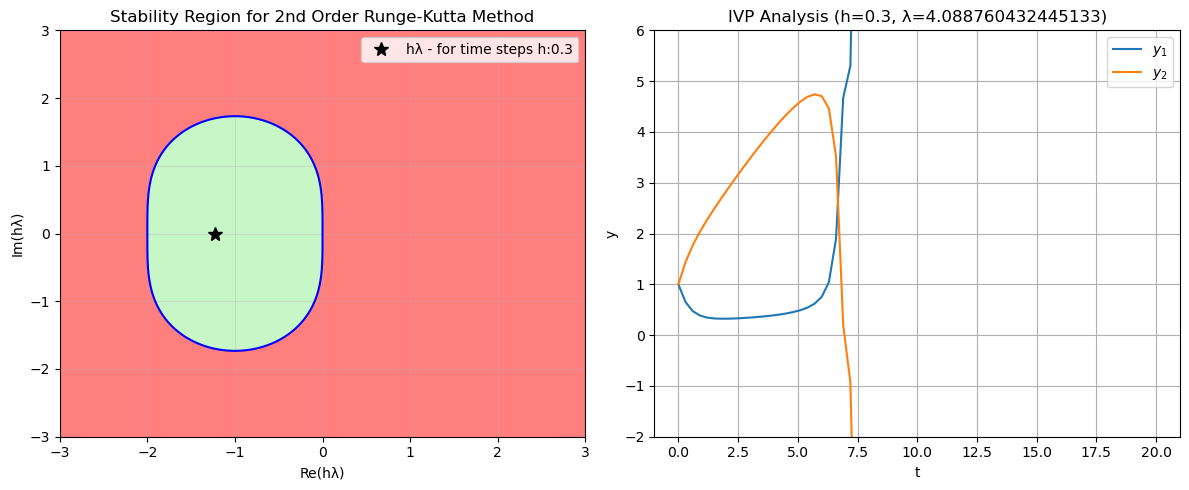

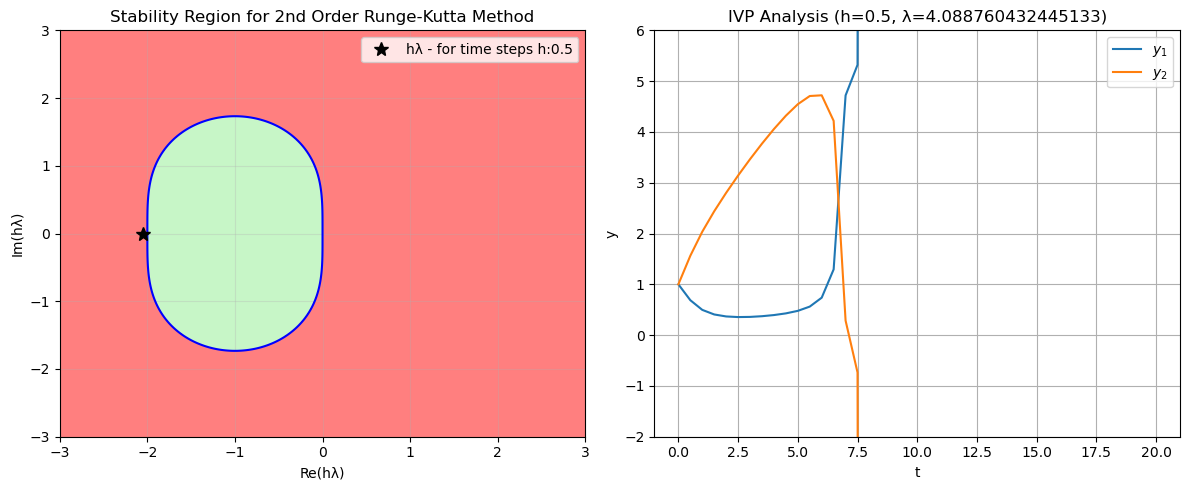

In [31]:
def plot_point(h, l):
    x = h * -l
    plt.plot(x.real, x.imag, '*', color='black', markersize=10, label=f'hλ - for time steps h:{h}')
    plt.legend()

h_values = [0.1, 0.3, 0.5]  
l = lambda_max
a = 1
b = 3


for h in h_values:
    plt.figure(figsize=(12, 5))
    
    # Left plot: Stability region 
    plt.subplot(1, 2, 1)
    explicit_RK_2_stability()        
    plot_point(h, l)          
    
    # Right plot: Exact and discretized solutions 
    plt.subplot(1, 2, 2)
    visualize_IVP(*IVP(lambda t,y : model(t,y,alpha=a,beta=b),np.array([1,1]),h,20,method=explicit_RK_2), ["$y_1$","$y_2$"])
    plt.xlabel("t")
    plt.ylabel("y")
    plt.title(f"IVP Analysis (h={h}, λ={l})")
    plt.xlim([-1, 21])
    plt.ylim([-2, 6])
    plt.legend()
    plt.grid()
    
    plt.tight_layout()
    plt.show()


In [32]:
#
# RK-4
#
def explicit_RK_4_stability():
    x_space = np.linspace(-3,3,1000)
    y_space = np.linspace(-3,3,1000)
    X, Y = np.meshgrid(x_space,y_space)
    def re(r,c):
        weights = [1,1, 1/2,1/6, 1/24]
        complex_n = (r + c*1j)
        powers = [weights[i]*complex_n**i for i in range(0,5)]
        total = sum(powers)
        norm = np.sqrt(total.real**2 + total.imag**2) 
        return norm

    condition = re(X,Y)
    plt.contourf(X, Y, condition, levels=[0,1], colors=['lightgreen'], alpha=0.5)
    plt.contourf(X, Y, condition, levels=[1,50], colors=['red'], alpha=0.5)

    condition = re(X,Y) < 1
    plt.contour(X, Y, condition, levels=1, colors='blue')   
    plt.grid()

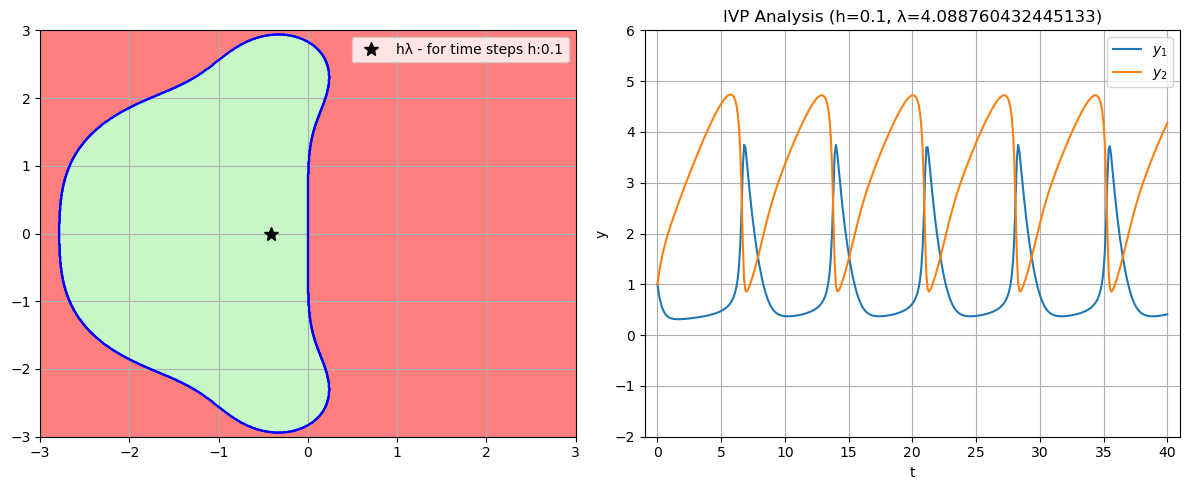

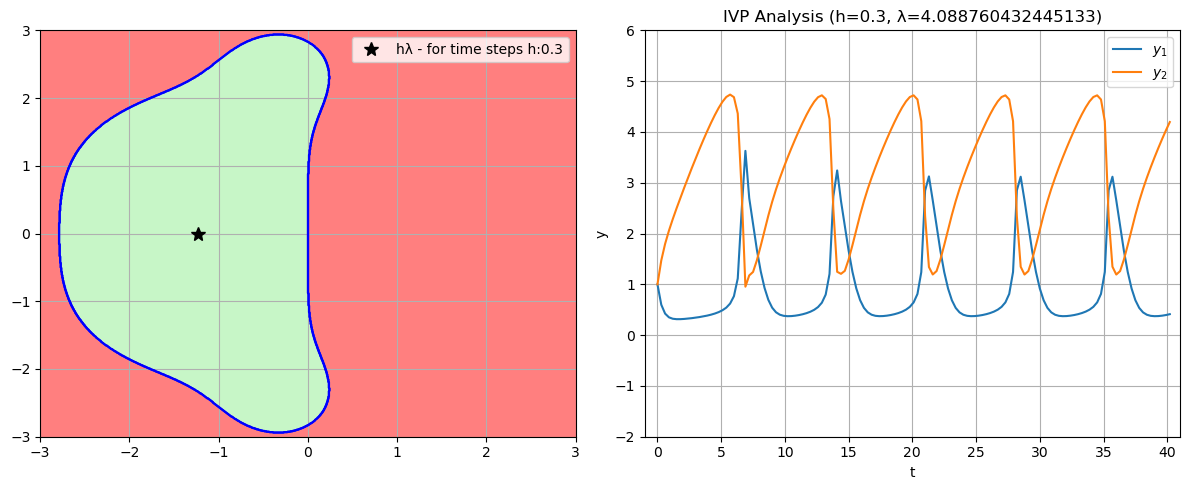

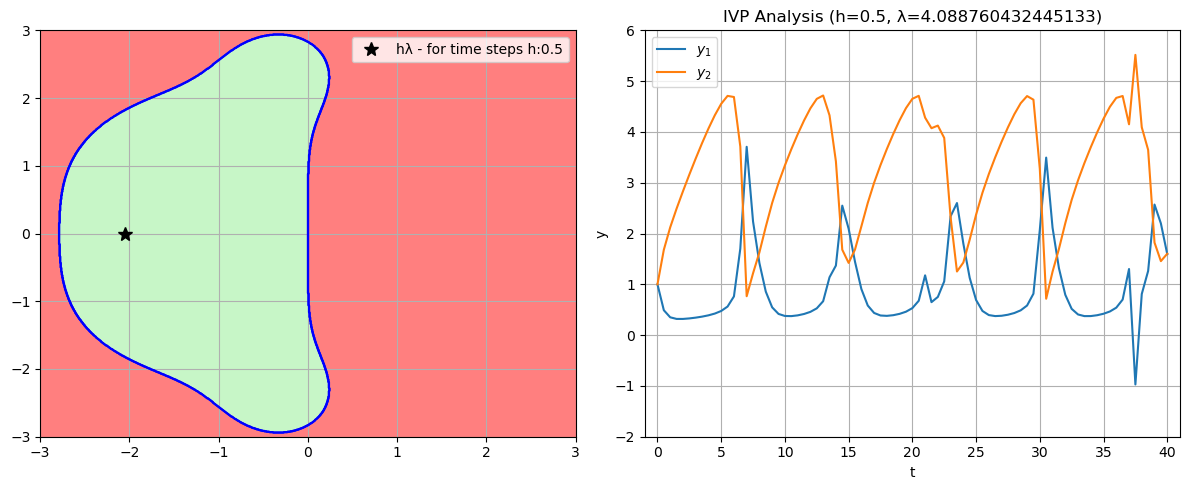

In [33]:
def plot_point(h, l):
    x = h * -l
    plt.plot(x.real, x.imag, '*', color='black', markersize=10, label=f'hλ - for time steps h:{h}')
    plt.legend()

h_values = [0.1, 0.3, 0.5]  
l = lambda_max
a = 1
b = 3


for h in h_values:
    plt.figure(figsize=(12, 5))
    
    # Left plot: Stability region 
    plt.subplot(1, 2, 1)
    explicit_RK_4_stability()        
    plot_point(h, l)          
    
    # Right plot: Exact and discretized solutions 
    plt.subplot(1, 2, 2)
    visualize_IVP(*IVP(lambda t,y : model(t,y,alpha=a,beta=b),np.array([1,1]),h,40,method=explicit_RK_4), ["$y_1$","$y_2$"])
    plt.xlabel("t")
    plt.ylabel("y")
    plt.title(f"IVP Analysis (h={h}, λ={l})")
    plt.xlim([-1, 41])
    plt.ylim([-2, 6])
    plt.legend()
    plt.grid()
    
    plt.tight_layout()
    plt.show()


### Drawbacks of explicit methods with fast and slow dynamics

The main issue with using explicit methods with fast and slow dynamics is choosing the step size. Because there are fast dynamics, it is important to have a small step size to ensure stability and convergences. However this causes unnecessary computational costs for the dynamically slow periods of the problem, because many steps are taken for regions where such detail is not needed. 

Similarly, when taking a larger step size to reduce the computational cost of the periods with slow dynamics, the fast dynamical regions loose be computed accurately.

The phenomena limiting the timestep is roundoff errors due to limited computer precision. If the timestep becomes too small, the computer is not able to accurately store the small changes in memory.

### TASK 4: Why is the Embedded Runge Kutta Method efficient?

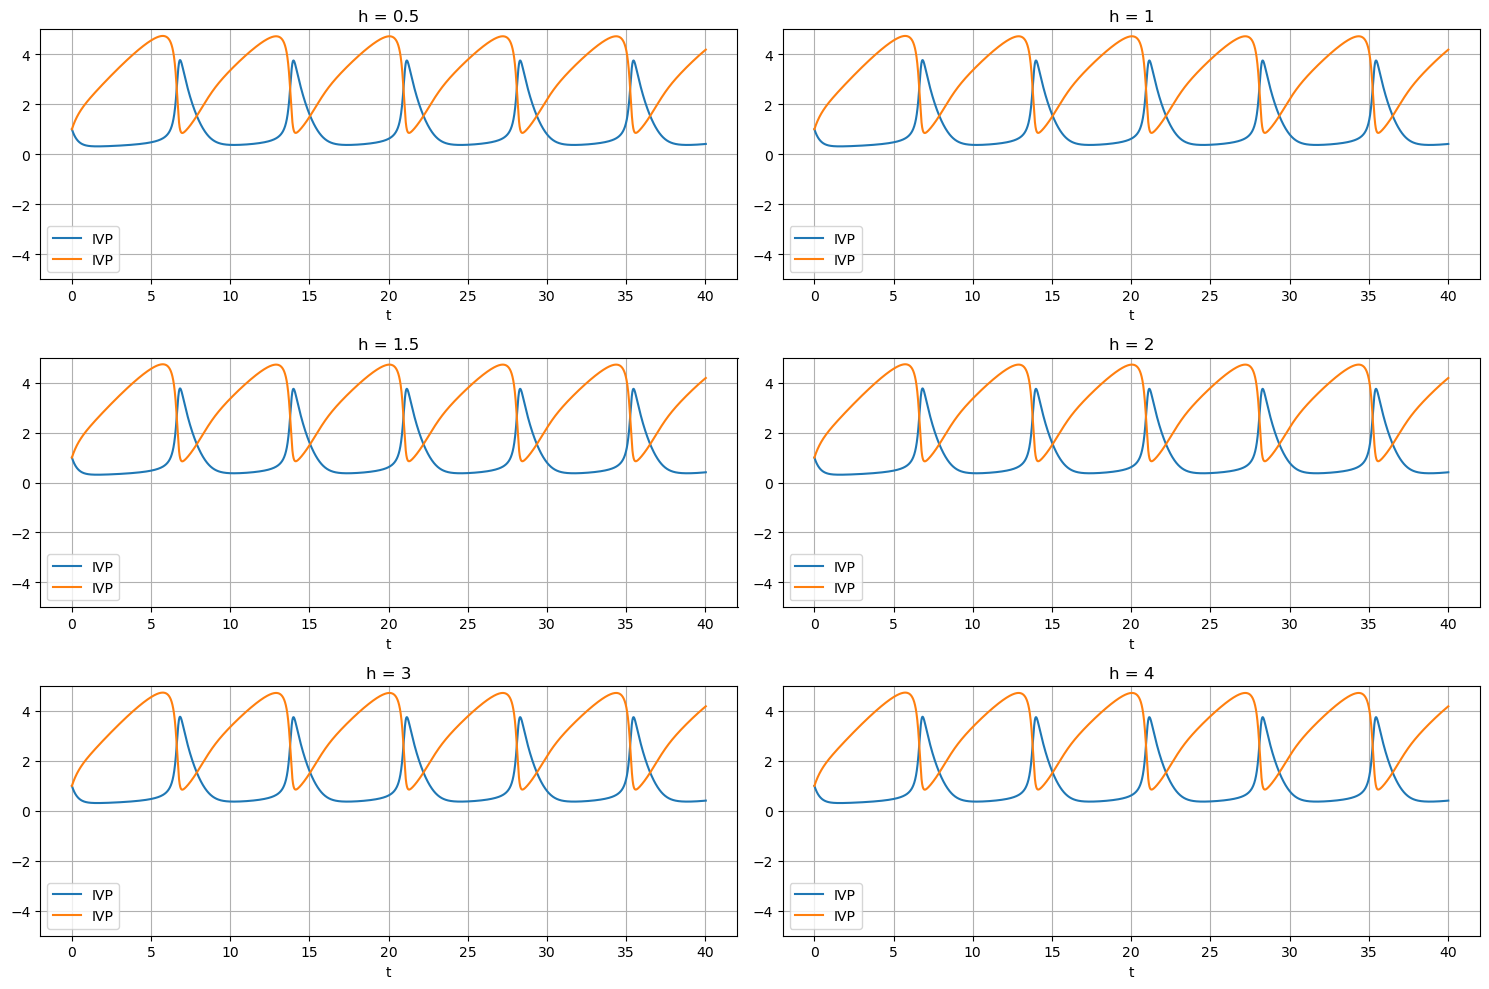

In [39]:
#
# technically testing the method for multiple time steps is unnecessary as the embedded method controlls the time step itself
#
m = lambda t,y : model(t,y)
plot_IVP(m,np.array([1,1]),40,method=embedd_RK_3, six_time_steps=[0.5,1,1.5,2,3,4])

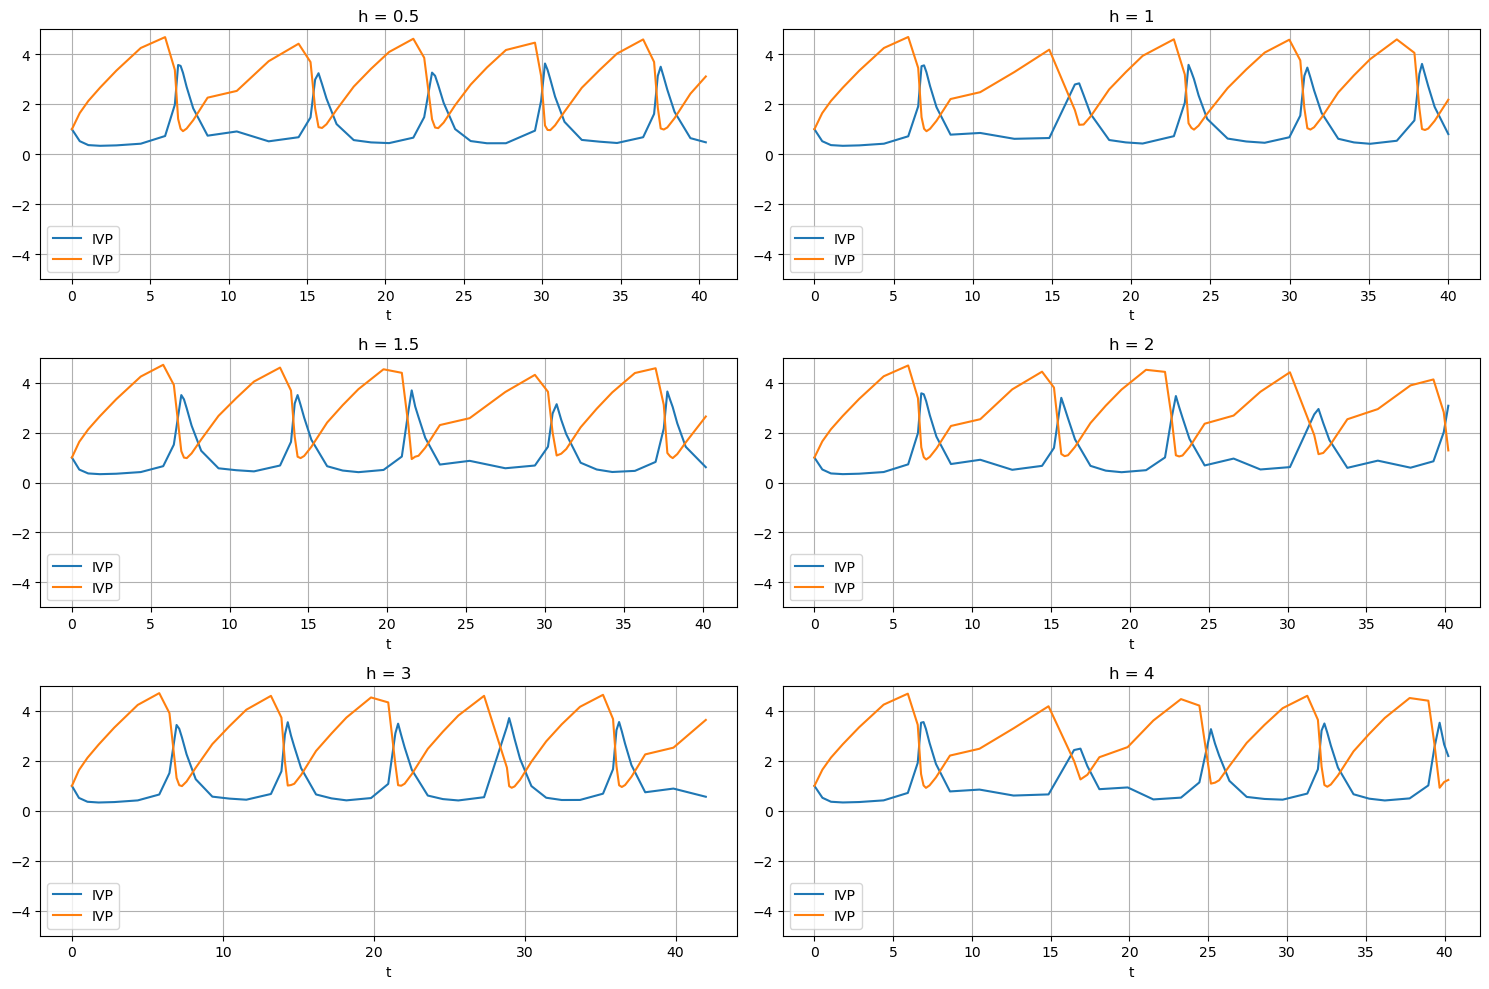

In [57]:
erk3 = lambda f,y,h,t : embedd_RK_3(f,y,h,t,tol=1e-1, debug=False)
#
# technically testing the method for multiple time steps is unnecessary as the embedded method controlls the time step itself
#
m = lambda t,y : model(t,y)
plot_IVP(m,np.array([1,1]),40,method=erk3, six_time_steps=[0.5,1,1.5,2,3,4])

#### Embeded Runge-Kuttas efficiency + order + usefulness + tolerance
The embedded Runge-Kutta method is so efficient for this problem because it adapts its step size in accordance with the dynamics of the system. When the system is in a slow-dynamic state, the embeded method notices small differences in the different order methods and thus is able to take larger time steps. However, when the system reaches its fast-dynamic region, the embedded method adapts and reduced the step size such that the fast-dynamic behaviour are accuractely computed.

The method is fourth order because it is stable and accurate without having to use an implicit scheme. Having a higher order method would be unnecessary.

Embedded methods are useful as they allow the use of computationally cheaper explicit methods. Because the step size is adapted based on estimated errors, it is possible to maximise the step size without violating the stability condition.

The tolerance is as expected.

## TASK 5: Stability of the Implicit Euler Method

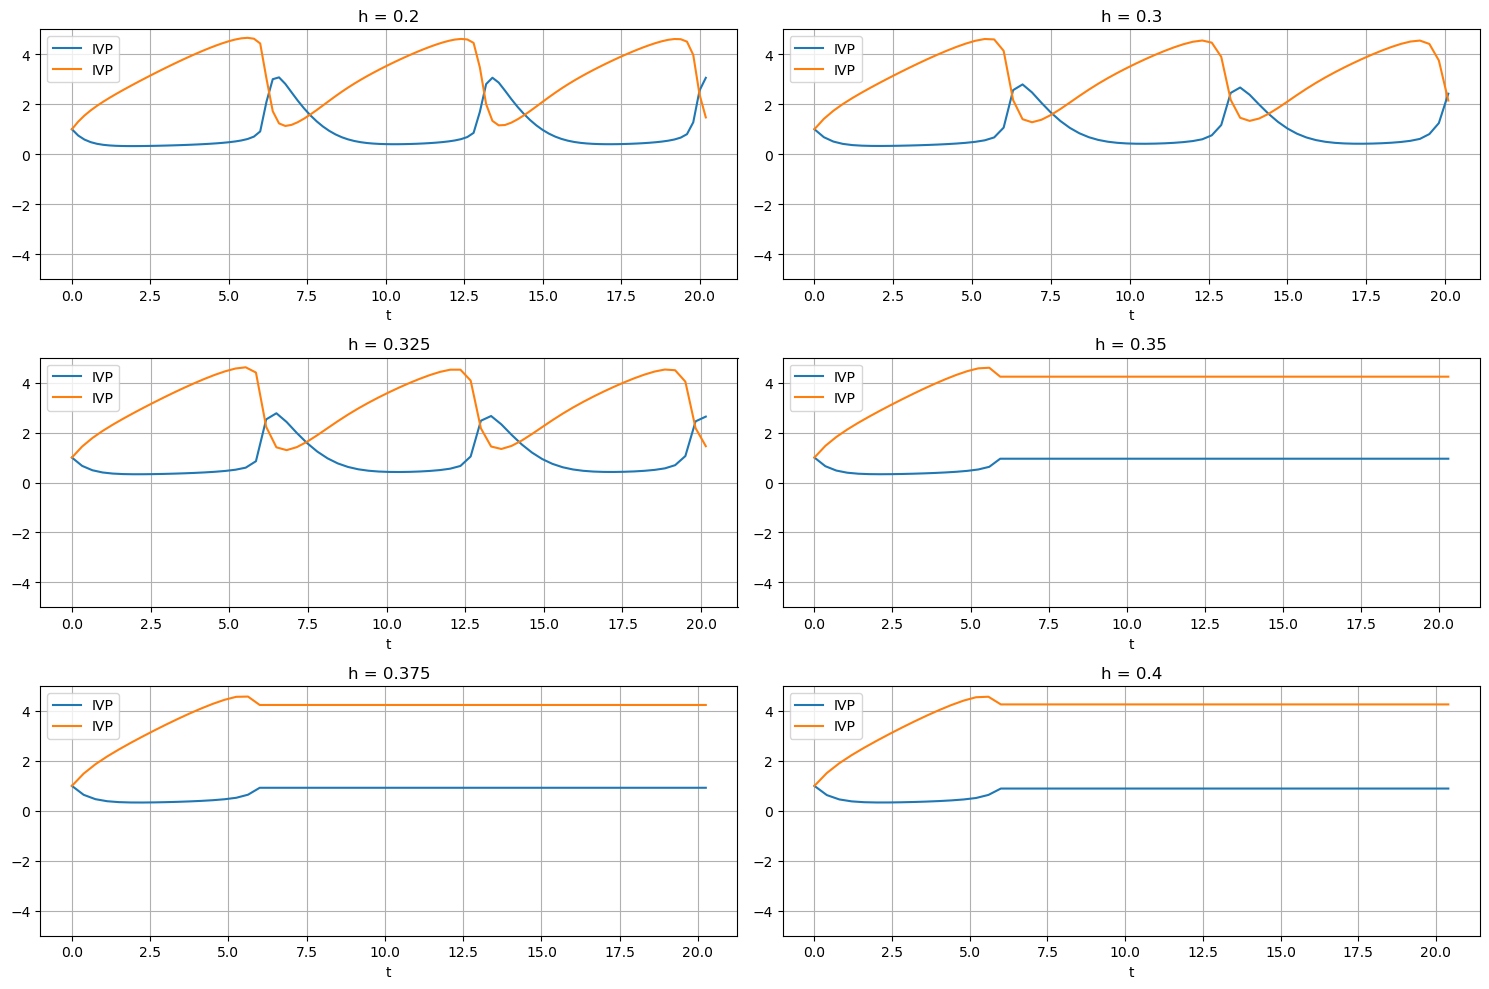

In [60]:
m = lambda t,y : model(t,y)
plot_IVP(m,np.array([1,1]),20,method=backward_euler,six_time_steps=[0.2,0.3,0.325,0.35,0.375,0.4])

In [61]:
#
# implicit euler
#
def implicit_stability():
    x_space = np.linspace(-3,3,1000)
    y_space = np.linspace(-3,3,1000)
    X, Y = np.meshgrid(x_space,y_space)
    def re(r,c):
        complex_n = r + c*1j
        total = 1/(1-complex_n)
        norm = np.sqrt(total.real**2 + total.imag**2) 
        return norm

    condition = re(X,Y)
    plt.contourf(X, Y, condition, levels=[0,1], colors=['lightgreen'], alpha=0.5)
    plt.contourf(X, Y, condition, levels=[1,100], colors=['red'], alpha=0.5)
    condition = re(X,Y) < 1
    plt.contour(X, Y, condition, levels=1, colors='blue')   
    plt.grid()

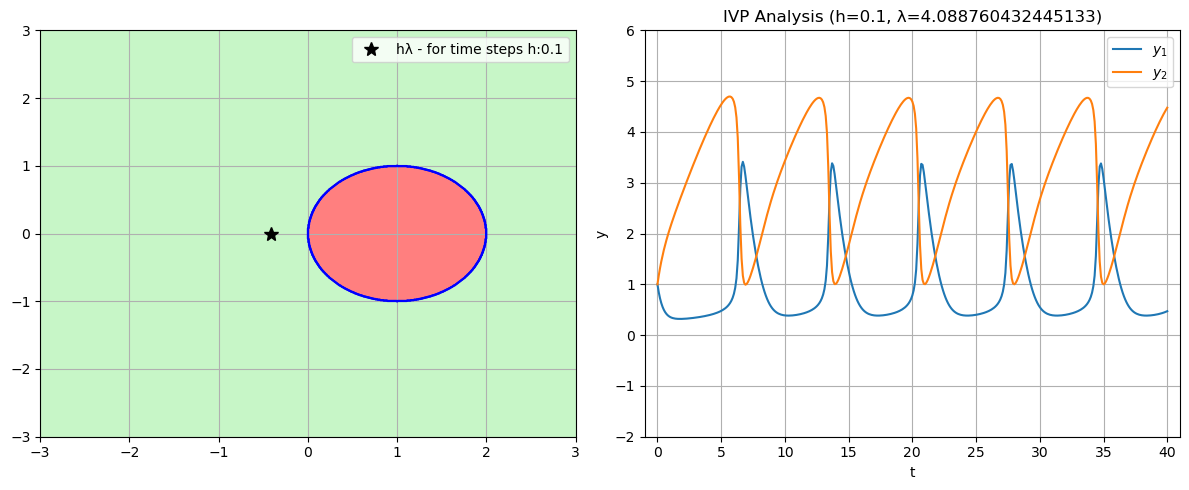

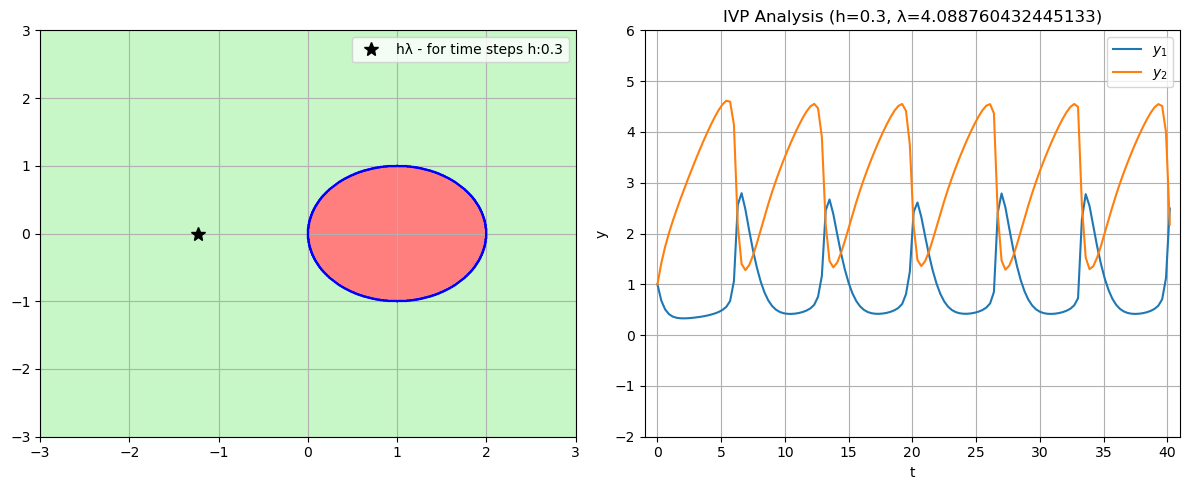

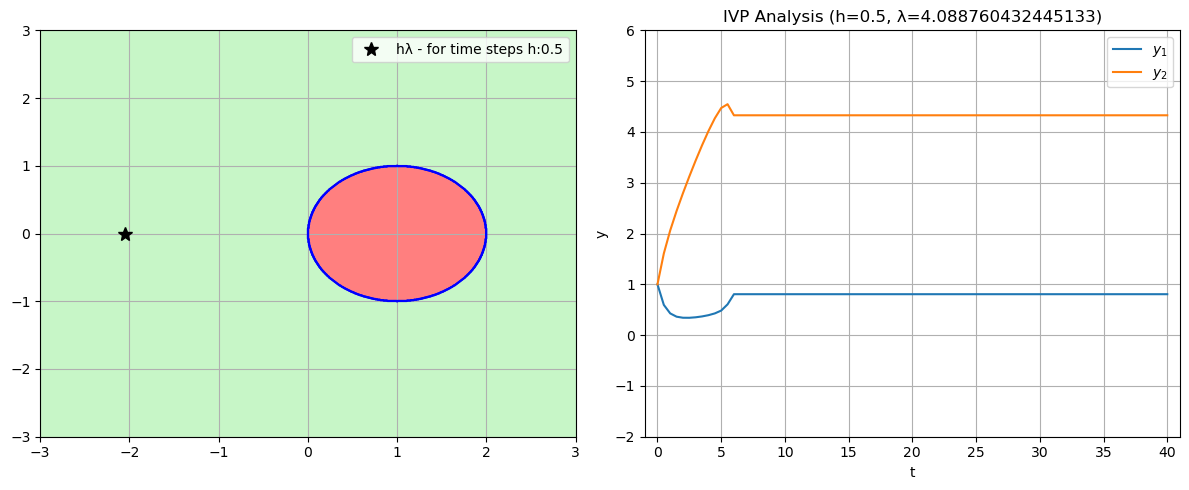

In [62]:
def plot_point(h, l):
    x = h * -l
    plt.plot(x.real, x.imag, '*', color='black', markersize=10, label=f'hλ - for time steps h:{h}')
    plt.legend()

h_values = [0.1, 0.3, 0.5]  
l = lambda_max
a = 1
b = 3


for h in h_values:
    plt.figure(figsize=(12, 5))
    
    # Left plot: Stability region 
    plt.subplot(1, 2, 1)
    implicit_stability()        
    plot_point(h, l)          
    
    # Right plot: Exact and discretized solutions 
    plt.subplot(1, 2, 2)
    visualize_IVP(*IVP(lambda t,y : model(t,y,alpha=a,beta=b),np.array([1,1]),h,40,method=backward_euler), ["$y_1$","$y_2$"])
    plt.xlabel("t")
    plt.ylabel("y")
    plt.title(f"IVP Analysis (h={h}, λ={l})")
    plt.xlim([-1, 41])
    plt.ylim([-2, 6])
    plt.legend()
    plt.grid()
    
    plt.tight_layout()
    plt.show()


The implicit euler method is stable for most time steps. If the timesteps become too large however the implicit method fails and determines that the quantities of both particles remain constant. The explicit euler method needs a time step of around 0.01 to be stable, the implicit euler method is stable with time steps between 0.2 and 0.3 and provides similar resolution to the explicit euler method.

### TASK 6: Radau5

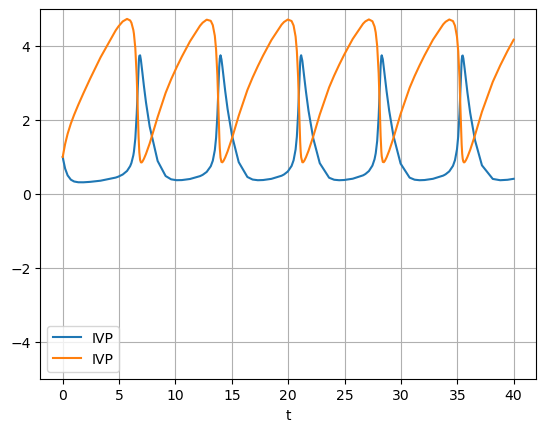

In [78]:
m = lambda t,y : model(t,y)
steps = []
def radau_gen(f,y,t):
    rad_obj = scp.integrate.Radau(f,0,y,t)
    while True:
        rad_obj.step()
        yield rad_obj.y, rad_obj.t, rad_obj.step_size
        if rad_obj.t == t:
            break
ts = [0]
ys = [[1,1]]
for y,t,h in radau_gen(m,np.array([1,1]),40):
    ts.append(t)
    ys.append(y)
    steps.append(h)
    
plt.plot(ts,ys, label=f"IVP")
plt.xlabel(f"t")
plt.ylim(-5,5)
plt.legend()
plt.grid()

In [80]:
#
# step sizes used by radau5
#
print("Smallest Step size:",min(steps), "\nLargest Step size:", max(steps))
print("Number of steps taken:", len(steps))

Smallest Step size: 0.02563991926746212 
Largest Step size: 1.3411410903621839
Number of steps taken: 143


#### Radau5 time steps + why is the method overkill?

It seems Radau5 used step sizes ranging from 0.026 to 1.341. 


Radau5 is overkill because a 3rd order embedded method is more than enough to ensure stability and accuracy. The extra accuracy and stability Radau5 provides is unnecessary, only adding extra computational costs. Especially when considering the vast difference in computational cost between explicit and implicit methods.